# Question 2-1

> **Note:** 
> 1. This is a starting point for how to structure your data project 
> 1. The `dataproject.py` file includes functions which can be in this notebook

In [114]:
#%pip install git+https://github.com/alemartinello/dstapi
#%pip install fredapi

In [115]:
import numpy as np
import pandas as pd

# APIs
from fredapi import Fred
from dstapi import DstApi

# plotting
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})

## Find data

### CPI

In [116]:
# access data in denmark statistics

PRIS113 = DstApi('PRIS113')
PRIS113.tablesummary(language='en')



Table PRIS113: Consumer price index by type and time
Last update: 2025-10-10T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TYPE,1,INDEKS,Consumer price index,INDEKS,Consumer price index,False
1,Tid,549,1980M01,1980M01,2025M09,2025M09,True


In [117]:
PRIS113.variable_levels('TYPE',language='en') # consumer price index


,id,text
0,INDEKS,Consumer price index


In [118]:
PRIS113.variable_levels('Tid',language='en') # time variable

,id,text
0,1980M01,1980M01
1,1980M02,1980M02
2,1980M03,1980M03
3,1980M04,1980M04
4,1980M05,1980M05
...,...,...
544,2025M05,2025M05
545,2025M06,2025M06
546,2025M07,2025M07
547,2025M08,2025M08


In [119]:
# a. set download parameters
params = {
    'table': 'PRIS113',
    'format': 'BULK', # semicolon separated file
    'lang': 'en',
    'variables': [
        {'code': 'TYPE', 'values': ['*']},
        {'code': 'TID', 'values': ['*']}, # '*' is everything
        ]
    }
# b. download
Priceindex = PRIS113.get_data(params=params)
# c. sort TID
Priceindex = Priceindex.sort_values(
    by='TID',
    key=lambda s: pd.to_datetime(s.str.replace('M', '-'), format='%Y-%m')
).reset_index(drop=True)
# d. TID to INT and INDHOLD to float
Priceindex['TID_int'] = (
    Priceindex['TID'].str.strip()
                      .str.replace('M', '', regex=False)
                      .astype('Int64')  # NA
)
Priceindex['INDHOLD'] = Priceindex['INDHOLD'].astype(float)
# e. display
display(Priceindex.head(5))
display(Priceindex.info())

,TYPE,TID,INDHOLD,TID_int
0,Consumer price index,1980M01,33.0,198001
1,Consumer price index,1980M02,33.3,198002
2,Consumer price index,1980M03,33.8,198003
3,Consumer price index,1980M04,34.0,198004
4,Consumer price index,1980M05,34.5,198005


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TYPE     549 non-null    object 
 1   TID      549 non-null    object 
 2   INDHOLD  549 non-null    float64
 3   TID_int  549 non-null    Int64  
dtypes: Int64(1), float64(1), object(2)
memory usage: 17.8+ KB


None

Pivot the table, and rename the columns

In [120]:

df_ = Priceindex.pivot_table(index='TID_int',columns=['TYPE'],values='INDHOLD')

df_ = df_.rename(columns={
    'Consumer price index': 'CPI Denmark',
    'TID':'year',
    })

df_.head(5)

TYPE,CPI Denmark
TID_int,
198001,33.0
198002,33.3
198003,33.8
198004,34.0
198005,34.5


Get year average CPI

In [121]:
# 1) 198001 → 1980-01-01， create DatetimeIndex
df_m = df_.copy()
df_m.index = pd.to_datetime(df_m.index.astype(str), format='%Y%m')

# 2) Year average CPI
annual_cpi = df_m['CPI Denmark'].resample('YE').mean()

# 3) Turn to Integer index
annual_cpi.index = annual_cpi.index.year
annual_cpi.index.name = 'year'

# DataFrame
annual_cpi = annual_cpi.to_frame('CPI Denmark')

Basic describe

In [122]:
annual_cpi.describe().style.format('{:.1f}')

,CPI Denmark
count,46.0
mean,79.8
std,22.7
min,34.8
25%,63.5
50%,80.7
75%,99.4
max,120.9


### HICP

In [123]:
# access Fed data
with open('/Users/lishixue/Documents/2025 winter/Programming for Economists/fredapi.txt', 'r') as f: fred_api_key = f.read()
fred = Fred(api_key=fred_api_key)

In [124]:
# What we need?
# Harmonized Index of Consumer Prices: All-Items HICP for Denmark
series = {'CP0000DKM086NEST': 'HICP Denmark'}

In [125]:
for k in series.keys():
    display(fred.search(k)[['title','frequency','units']].T)

series id,CP0000DKM086NEST
title,Harmonized Index of Consumer Prices: All-Items...
frequency,Monthly
units,Index 2015=100


In [126]:
fred.get_series('CP0000DKM086NEST')

1996-01-01     70.4
1996-02-01     70.8
1996-03-01     71.3
1996-04-01     71.5
1996-05-01     71.7
              ...  
2025-05-01    120.5
2025-06-01    120.9
2025-07-01    122.9
2025-08-01    122.0
2025-09-01    121.8
Length: 357, dtype: float64

In [127]:
#download data from fred
data = {}
var = fred.get_series('CP0000DKM086NEST')
var.name = 'HICP Denmark'
data['HICP Denmark'] = var
print(f'Downloaded {'CP0000DKM086NEST':15s} from FRED and saved it as {'HICP Denmark':15s}')

# Resample to annual frequency
data['HICP Denmark'] = var.resample("YE").mean()

# Combine and drop any rows with missing observations
df = pd.DataFrame(data)
df = df.dropna() # drop any rows with missing observations
df.head()

# Change index to year only
df.index = df.index.year
df = df.rename_axis('year')
df.head()




Downloaded CP0000DKM086NEST from FRED and saved it as HICP Denmark   


,HICP Denmark
year,
1996,71.566667
1997,72.950000
1998,73.908333
1999,75.416667
2000,77.491667


### Graph

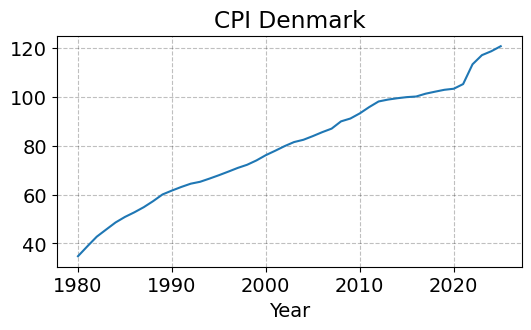

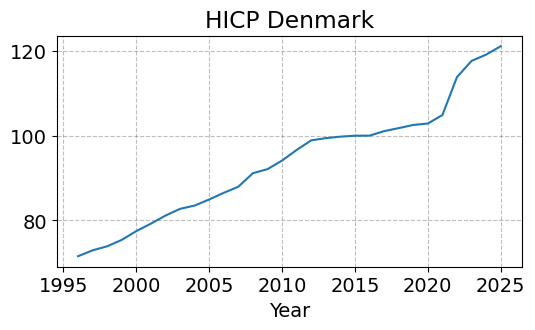

In [128]:
for col in annual_cpi.columns:
    
    fig = plt.figure(figsize=(6,3))
    ax = fig.add_subplot(111)
    ax.plot(annual_cpi.index, annual_cpi[col])
    ax.set_title(col)
    ax.set_xlabel('Year')

for col in df.columns:

    fig = plt.figure(figsize=(6,3))
    ax = fig.add_subplot(111)
    ax.plot(df.index, df[col])
    ax.set_title(col)
    ax.set_xlabel('Year')

Combine together

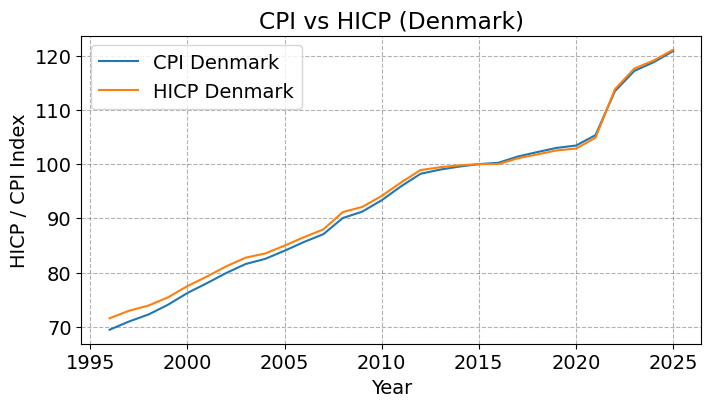

In [129]:
s1 = annual_cpi['CPI Denmark']
s2 = df['HICP Denmark']

# Match same years
years = s1.index.intersection(s2.index)
s1c = s1.loc[years]
s2c = s2.loc[years]

# Combine together
df_combined = pd.DataFrame({
    'CPI Denmark': s1c,
    'HICP Denmark': s2c
})
df_combined.head()

# Draw at the same plot
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(years, s1c, label='CPI Denmark')
ax.plot(years, s2c, label='HICP Denmark')
ax.set_title('CPI vs HICP (Denmark)')
ax.set_xlabel('Year')
ax.set_ylabel('HICP / CPI Index')
ax.legend()
ax.grid(True, ls='--', alpha=0.3)


#### Short Answer:
The key difference between HICP and CPI is whether the index includes own-occupied hosuing. Accroding to the plot above, both indexs are nearly consistent.


# Question 2-2

### 1. Compare HICP (All Items) across countries

In [130]:
countriesHICP = {'CP0000DKM086NEST': 'HICP Denmark', 
                 'CP0000ATM086NEST': 'HICP Austria',
                 'CP0000EZ19M086NEST': 'HICP Euro Area',
                 'CP0000USM086NEST': 'HICP USA'
                 }

In [131]:
for k in countriesHICP.keys():
    display(fred.search(k)[['title','frequency','units']].T)

series id,CP0000DKM086NEST
title,Harmonized Index of Consumer Prices: All-Items...
frequency,Monthly
units,Index 2015=100


series id,CP0000ATM086NEST
title,Harmonized Index of Consumer Prices: All-Items...
frequency,Monthly
units,Index 2015=100


series id,CP0000EZ19M086NEST
title,Harmonized Index of Consumer Prices: All-Items...
frequency,Monthly
units,Index 2015=100


series id,CP0000USM086NEST
title,Harmonized Index of Consumer Prices: All-Items...
frequency,Monthly
units,Index 2015=100


In [132]:
data1 = {}
for code,name in countriesHICP.items():
    var = fred.get_series(code)
    var.name = name
    data1[name] = var
    print(f'Downloaded {code:15s} from FRED and saved it as {name:15s}')

## Resample to annual frequency
for name,var in data1.items():
    data1[name] = var.resample("YE").mean()

## Combine and drop any rows with missing observations
df1 = pd.concat(data1, axis=1).dropna()

# Retain after 2019
df1 = df1.loc['2019':]    

## Change index to year
# Change index to year only
df1.index = df1.index.year
df1 = df1.rename_axis('year')
df1.head()

Downloaded CP0000DKM086NEST from FRED and saved it as HICP Denmark   
Downloaded CP0000ATM086NEST from FRED and saved it as HICP Austria   
Downloaded CP0000EZ19M086NEST from FRED and saved it as HICP Euro Area 
Downloaded CP0000USM086NEST from FRED and saved it as HICP USA       


,HICP Denmark,HICP Austria,HICP Euro Area,HICP USA
year,,,,
2019,102.533333,106.983333,104.800000,105.986667
2020,102.875000,108.468333,105.064167,106.801667
2021,104.875000,111.460833,107.783333,112.500833
2022,113.825000,121.066667,116.820000,122.265000
2023,117.641667,130.399167,123.135000,125.940833


### Graph

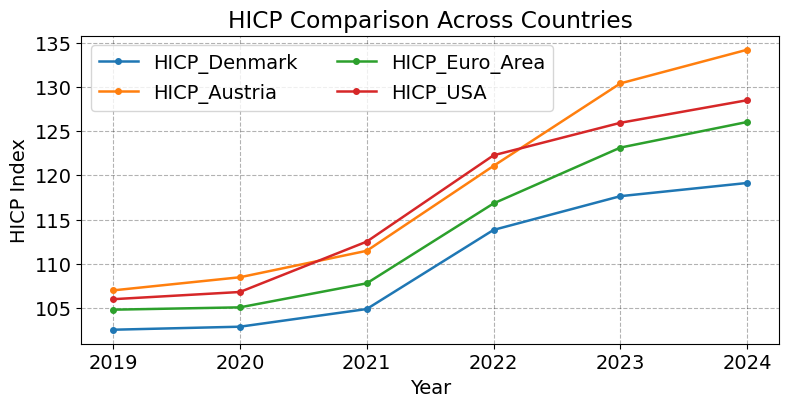

In [133]:
HICP_DK = df1['HICP Denmark']
HICP_AT = df1['HICP Austria']
HICP_EA = df1['HICP Euro Area']
HICP_US = df1['HICP USA']

# Match same years
all_series = {'HICP_Denmark': HICP_DK, 'HICP_Austria': HICP_AT, 'HICP_Euro_Area': HICP_EA, 'HICP_USA': HICP_US}
df_all = pd.concat(all_series, axis=1).dropna().sort_index()

# Draw at the same plot
fig, ax = plt.subplots(figsize=(9, 4))

for col in df_all.columns:
    ax.plot(
        df_all.index, df_all[col],
        marker='o',           
        markersize=4,         
        linewidth=1.8,
        label=col
    )
ax.set_xlabel('Year')
ax.set_ylabel('HICP Index')
ax.set_title('HICP Comparison Across Countries')
ax.legend(ncol=2)          
ax.grid(True, ls='--', alpha=0.3)

### 2. Compute and compare the 12-month HICP inflation rate across countries

$$
\pi_t = \left( \frac{\mathrm{HICP}_t}{\mathrm{HICP}_{t-12}} - 1 \right) \times 100
$$


In [134]:
data_m = {}
for code,name in countriesHICP.items():
    var = fred.get_series(code)
    var.name = name
    data_m[name] = var
    print(f'Downloaded {code:15s} from FRED and saved it as {name:15s}')
# 1) Combine each countries' HICP
df_m = pd.concat(data_m, axis=1).sort_index()

# 2) from 2019
df_m = df_m.loc['2019-01':]

# 3) inflation（YoY）
yoy = df_m.pct_change(12) * 100
# yoy = (np.log(df_m) - np.log(df_m.shift(12))) * 100

# 4) drop na
yoy = yoy.dropna()
yoy.head()  


Downloaded CP0000DKM086NEST from FRED and saved it as HICP Denmark   
Downloaded CP0000ATM086NEST from FRED and saved it as HICP Austria   
Downloaded CP0000EZ19M086NEST from FRED and saved it as HICP Euro Area 
Downloaded CP0000USM086NEST from FRED and saved it as HICP USA       


/var/folders/7z/npwd4mkj50g10rrf3zlkgr4m0000gn/T/ipykernel_50087/4028967904.py:14: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  yoy = df_m.pct_change(12) * 100


,HICP Denmark,HICP Austria,HICP Euro Area,HICP USA
2020-01-01,0.785855,2.168150,1.359619,2.223500
2020-02-01,0.684262,2.187293,1.219748,2.050940
2020-03-01,0.292969,1.582249,0.747484,1.042555
2020-04-01,-0.097371,1.521658,0.313987,-0.471076
2020-05-01,-0.194742,0.587796,0.085519,-0.742760


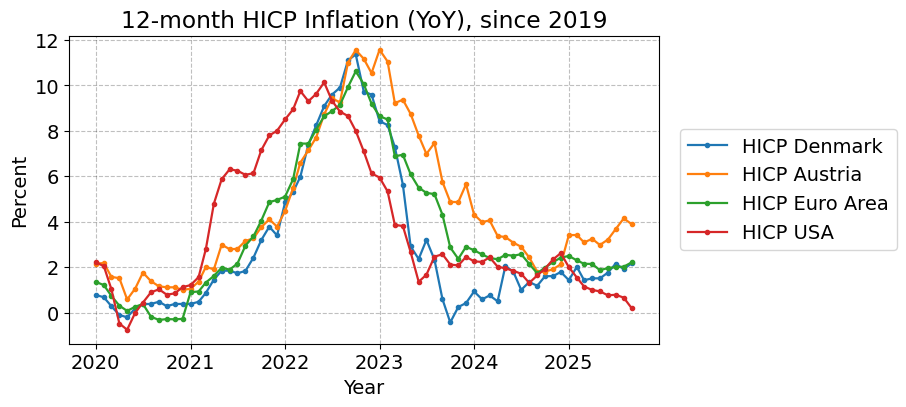

In [135]:
# 5) Plotting
fig, ax = plt.subplots(figsize=(9,4))
for col in yoy.columns:
    ax.plot(yoy.index, yoy[col], marker='o', markersize=3, linewidth=1.6, label=col)
ax.set_title('12-month HICP Inflation (YoY), since 2019')
ax.set_xlabel('Year'); ax.set_ylabel('Percent')
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
fig.subplots_adjust(right=0.78)

### 3. Print the min., max., and mean 12-month inflation rate year-by-year and across countries

In [136]:
# 1) select last observation of each year (usually December) for YoY
yoy_year = yoy.resample('Y').last()
yoy_year.index = yoy_year.index.year
yoy_year.index.name = 'year'

# 2) Calculate min, max, mean across countries
stats = pd.DataFrame({
    'min':  yoy_year.min(axis=1),
    'max':  yoy_year.max(axis=1),
    'mean': yoy_year.mean(axis=1),
})

# 3) which country has min and max
who = pd.DataFrame({
    'min_country': yoy_year.idxmin(axis=1),
    'max_country': yoy_year.idxmax(axis=1),
})

summary = stats.join(who)

print(summary.round(2))

       min    max  mean     min_country   max_country
year                                                 
2020 -0.27   1.13  0.57  HICP Euro Area      HICP USA
2021  3.40   8.01  5.04    HICP Denmark      HICP USA
2022  6.13  10.54  8.86        HICP USA  HICP Austria
2023  0.43   5.65  2.86    HICP Denmark  HICP Austria
2024  1.79   2.62  2.24    HICP Denmark      HICP USA
2025  0.20   3.90  2.13        HICP USA  HICP Austria


/var/folders/7z/npwd4mkj50g10rrf3zlkgr4m0000gn/T/ipykernel_50087/4223572299.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yoy_year = yoy.resample('Y').last()


### Summary

Since 2019, all countries have experienced the same inflation cycle, but with significant differences in intensity and speed:
* Austria has the highest cumulative increase and stickiness
* The United States peaked first and deflated the fastest
* Denmark has the most significant decline in Europe
* The eurozone as a whole is somewhere in between

By 2024-2025, the cross-national inflation rate has converged significantly to around 2%, but it is still higher in Austria and lower in the United States.

# Question 3

### Energy price v.s. HICP inflation

* Idea: Using Brent crude oil as a proxy for energy costs, I'll check how the YoY oil price correlates with the YoY HICP rates for various countries.

* Why Brent crude oil ? Brent crude oil is a primary global benchmark for oil pricing.

In [137]:
crudeoil = {'DCOILBRENTEU':'Brent Crude Oil Price'}
for k in crudeoil.keys():
    display(fred.search(k)[['title','frequency','units']].T)


series id,DCOILBRENTEU
title,Crude Oil Prices: Brent - Europe
frequency,Daily
units,Dollars per Barrel


In [143]:
fred.get_series('DCOILBRENTEU')

1987-05-20    18.63
1987-05-21    18.45
1987-05-22    18.55
1987-05-25    18.60
1987-05-26    18.63
              ...  
2025-10-14    63.00
2025-10-15    62.33
2025-10-16    61.08
2025-10-17    61.23
2025-10-20    60.71
Length: 10024, dtype: float64

In [144]:
#download data from fred
data = {}
brent_m   = fred.get_series('DCOILBRENTEU').resample('MS').mean() 
brent_m.name = 'Brent YoY'
data['Brent YoY'] = brent_m

df = pd.concat(data, axis=1).sort_index()
# Change to YoY
df  = df.loc['2019-01':]
brent_yoy = df.pct_change(12, fill_method=None) * 100
brent_yoy.name = 'Brent YoY'
brent_yoy = brent_yoy.dropna() 

brent_yoy.index = brent_yoy.index.to_period('M')
brent_yoy = brent_yoy.rename_axis('time')
brent_yoy.head()

,Brent YoY
time,
2020-01,7.130014
2020-02,-12.982231
2020-03,-51.599554
2020-04,-74.199579
2020-05,-58.805547


In [145]:
for code,name in countriesHICP.items():
    var = fred.get_series(code)
    var.name = name
    data[name] = var
    print(f'Downloaded {code:15s} from FRED and saved it as {name:15s}')
# 1) Combine each countries' HICP
df_m = pd.concat(data, axis=1).sort_index()

# 2) from 2019
df_m = df_m.loc['2019-01':]

# 3) inflation（YoY）
yoy = df_m.pct_change(12) * 100
# yoy = (np.log(df_m) - np.log(df_m.shift(12))) * 100

# 4) drop na
yoy = yoy.dropna()
yoy.head()  

Downloaded CP0000DKM086NEST from FRED and saved it as HICP Denmark   
Downloaded CP0000ATM086NEST from FRED and saved it as HICP Austria   
Downloaded CP0000EZ19M086NEST from FRED and saved it as HICP Euro Area 
Downloaded CP0000USM086NEST from FRED and saved it as HICP USA       


/var/folders/7z/npwd4mkj50g10rrf3zlkgr4m0000gn/T/ipykernel_50087/794413132.py:13: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  yoy = df_m.pct_change(12) * 100


,Brent YoY,HICP Denmark,HICP Austria,HICP Euro Area,HICP USA
2020-01-01,7.130014,0.785855,2.168150,1.359619,2.223500
2020-02-01,-12.982231,0.684262,2.187293,1.219748,2.050940
2020-03-01,-51.599554,0.292969,1.582249,0.747484,1.042555
2020-04-01,-74.199579,-0.097371,1.521658,0.313987,-0.471076
2020-05-01,-58.805547,-0.194742,0.587796,0.085519,-0.742760


Now check the plot and see if we can find something

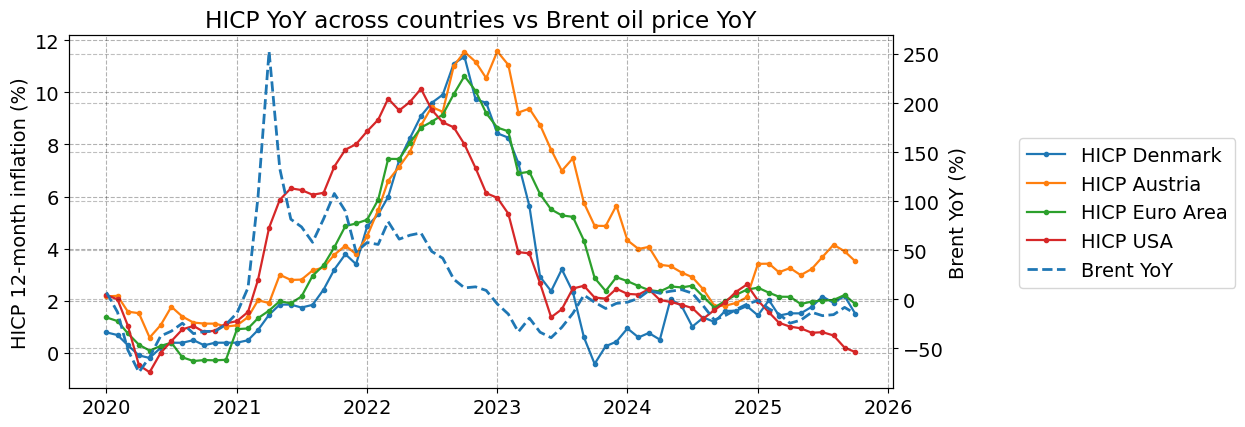

In [146]:

import matplotlib.dates as mdates

plot_df = yoy.sort_index()

countries = [c for c in plot_df.columns if c != 'Brent YoY']

fig, ax1 = plt.subplots(figsize=(10, 4.5))

# left axis：each country HICP YoY
for col in countries:
    ax1.plot(plot_df.index, plot_df[col], marker='o', markersize=3, linewidth=1.6, label=col)
ax1.set_ylabel('HICP 12-month inflation (%)')
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.grid(True, ls='--', alpha=0.3)

# Right axis：Brent YoY（dashedline）
ax2 = ax1.twinx()
ax2.plot(plot_df.index, plot_df['Brent YoY'], linestyle='--', linewidth=2.0, label='Brent YoY')
ax2.set_ylabel('Brent YoY (%)')

# place the legend outside the plot area
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

fig.legend(h1+h2, l1+l2,
           loc='center left', bbox_to_anchor=(1.02, 0.5))

fig.subplots_adjust(right=0.78)
ax1.set_title('HICP YoY across countries vs Brent oil price YoY')
plt.tight_layout()


<span style="color:red">But looks a bit messy!!</span>

Therefore, I use average HICP YoY across countries to check for the patterns.

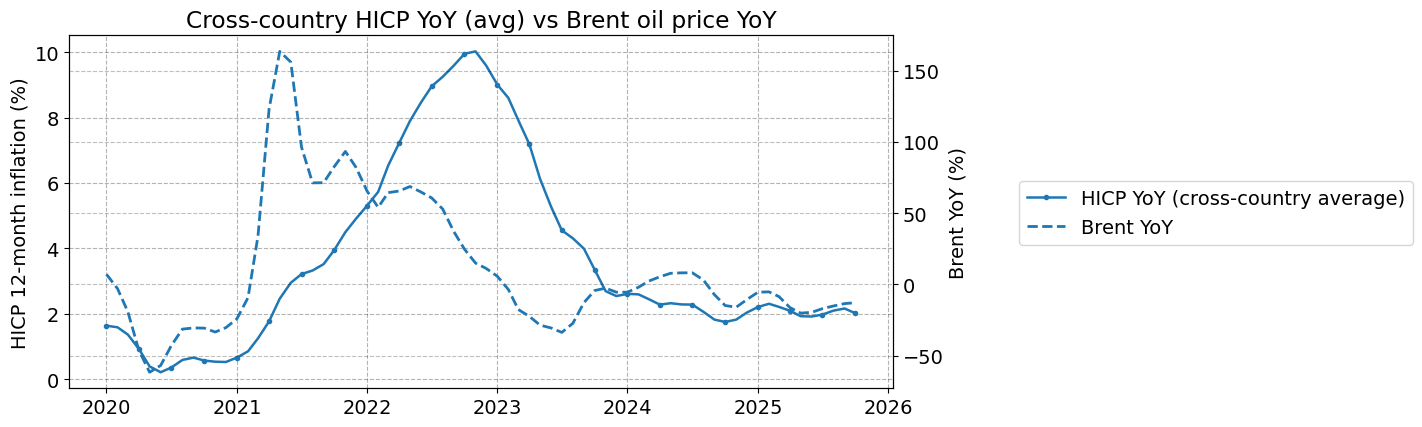

In [147]:
plot_df = yoy.sort_index()
countries = [c for c in plot_df.columns if c != 'Brent YoY']

hicp_mean = plot_df[countries].mean(axis=1).rolling(3, min_periods=1).mean()
brent_sm  = plot_df['Brent YoY'].rolling(3, min_periods=1).mean()

fig, ax1 = plt.subplots(figsize=(10, 4.5))
ax1.plot(hicp_mean.index, hicp_mean, marker='o', markersize=3, markevery=3,
         linewidth=1.8, label='HICP YoY (cross-country average)')
ax1.set_ylabel('HICP 12-month inflation (%)')
ax1.grid(True, ls='--', alpha=0.3)
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax2 = ax1.twinx()
ax2.plot(brent_sm.index, brent_sm, linestyle='--', linewidth=2.0, label='Brent YoY')
ax2.set_ylabel('Brent YoY (%)')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

fig.legend(h1+h2, l1+l2,
           loc='center left', bbox_to_anchor=(1.02, 0.5))

fig.subplots_adjust(right=0.78)

ax1.set_title('Cross-country HICP YoY (avg) vs Brent oil price YoY')
plt.tight_layout()


### Takeaways

* The surge in oil prices in 2022 contributed significantly to inflation; after oil prices fell, inflation followed suit.

* Brent oil price appears to be a leading indicator of inflation

* The United States and Europe were affected to different degrees (the United States peaked earlier and fell back faster).